# Binary Formats

Last time, we worked directly with byte-level data.  Input and output of binary data is reasonably straightforward given a known structure.  It is common for commercial software to use [proprietary data formats](https://en.wikipedia.org/wiki/Proprietary_software#Proprietary_file_formats_and_protocols), and [hundreds of formats](https://en.wikipedia.org/wiki/List_of_file_formats) exist for a wide variety of applications.  In the scientific community, a variety of [formats](https://en.wikipedia.org/wiki/List_of_file_formats#Scientific_data_(data_exchange)) were developed to facilitate the exchange of large, scientific data sets, including the popular [HDF5 format](https://portal.hdfgroup.org/display/HDF5/HDF5).  Other formats have been developed specifically to support visualization of large data sets; of these, we'll explore the [VTK formats](https://vtk.org/wp-content/uploads/2015/04/file-formats.pdf).  Although the HDF5 and VTK formats have very different purposes, their specifications are well developed and serve as good examples for those navigating the use of such third-party formats.

## HDF5

Of the scientific-data  developed, perhaps the [Hierarchical Data Format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is the most widely used.

The actual, on-file, binary format is rarely important to know, but the in-file, data structure is.  


That [structure is like a file directory](https://portal.hdfgroup.org/display/HDF5/Introduction+to+HDF5#IntroductiontoHDF5-hdf5desc):

```python
/                 # root GROUP
/SimOut/          ## GROUP containing simulation output
  data2darray     ## a DATASET, 2-D array of doubles
        DATATYPE: H5T_NATIVE_DOUBLE,
       DATASPACE: {rank:2, dim=(5,3)},
      PROPERTIES: {layout: contiguous},
      ATTRIBUTES: {name1: value1, name2: value2, ...}
            DATA: ...
  data3darray     ## a DATASET, 3-D array of integers
        DATATYPE: H5T_NATIVE_INT,
       DATASPACE: {rank:3, dim=(4,3,2)},
      PROPERTIES: {layout: contiguous},
      ATTRIBUTES: {...}
            DATA: ...
/Viz/             ## GROUP containing viz output
  metadata=
    {ATTRIBUTES: {...} # groups can have attributes
  image1          ## a DATASET, an image (2-D array?)
    ...
  image2  
     .... and so on
```

### Creating an HDF5 File

In [1]:
import h5py
import numpy as np
name =  'mytestfile.hdf5'
!rm mytestfile.hdf5 # makes sure it's not already there
fh = h5py.File('mytestfile.hdf5', 'w')
SimOut = fh.create_group('SimOut')
data2darray = SimOut.create_dataset("data2darray", data=np.random.randint(0, 10, (5, 4)))
data2darray.attrs["name1"] = "value1"
data2darray.attrs["name2"] = "value2"
data3darray = SimOut.create_dataset("data3darray", data=np.random.rand(4,3,2))
Viz = fh.create_group('Viz')
image1 = Viz.create_dataset("image1", data=[1,2,3])
image2 = Viz.create_dataset("image2", data=[2,3,4])
fh.close()

In [2]:
!h5dump mytestfile.hdf5

HDF5 "mytestfile.hdf5" {
GROUP "/" {
   GROUP "SimOut" {
      DATASET "data2darray" {
         DATATYPE  H5T_STD_I64LE
         DATASPACE  SIMPLE { ( 5, 4 ) / ( 5, 4 ) }
         DATA {
         (0,0): 6, 3, 8, 3,
         (1,0): 8, 8, 2, 5,
         (2,0): 2, 7, 4, 6,
         (3,0): 9, 6, 4, 6,
         (4,0): 9, 3, 4, 5
         }
         ATTRIBUTE "name1" {
            DATATYPE  H5T_STRING {
               STRSIZE H5T_VARIABLE;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_UTF8;
               CTYPE H5T_C_S1;
            }
            DATASPACE  SCALAR
            DATA {
            (0): "value1"
            }
         }
         ATTRIBUTE "name2" {
            DATATYPE  H5T_STRING {
               STRSIZE H5T_VARIABLE;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_UTF8;
               CTYPE H5T_C_S1;
            }
            DATASPACE  SCALAR
            DATA {
            (0): "value2"
            }
         }
      }
      DATASET

### Reading an HDF5 File 

Writing it out is easy enough, but how do we get that back in?

In [3]:
import h5py
import numpy as np
name =  'mytestfile.hdf5'
fh = h5py.File('mytestfile.hdf5', 'r')
d2da = fh.get("/SimOut/data2darray")
print("shape = ", d2da.shape)
print("data = ", d2da[()]) # or d2da.value, which is deprecated
fh.close()

shape =  (5, 4)
data =  [[6 3 8 3]
 [8 8 2 5]
 [2 7 4 6]
 [9 6 4 6]
 [9 3 4 5]]


The reason HDF5 is so useful is because this API is available in the core C/C++ language used to build HDF5 and several other languages (Python, MATLAB, Fortran, etc.).

## VTK

The Visualization Toolkit (VTK) defines a variety of formats for storing data in a way that is easy to load, inspect, and modify in visualization tools like [Paraview]() and [VisIt]().  

VTK defines two broad classes of data formats: the [legacy](https://lorensen.github.io/VTKExamples/site/VTKFileFormats/#simple-legacy-formats) formats and the [XML](https://lorensen.github.io/VTKExamples/site/VTKFileFormats/#xml-file-formats) formats.  Despite being "legacy", these formats are still widely used.  The XML variants give a bit more flexibility for parallel file input and output, but the underlying data organization is quite similar.  Here, we'll explore the legacy formats.

### Making a VTK File In Text Format

The VTK formats are easy enough to write directly to ASCII-formatted text files.  For large data, the binary variants of these formats is preferred, so we'll start with the text version and then do the same in binary using the `vtk` module.

For some sample data, we'll evaluate the function $f(x,y,z) = xy^2\sin(z)$ on the grid $x,y,z \in [0, 1]$.  Here, we'll use 3, 4, and 5 equally-spaced divisions in each dimension.  We'll also define the 3-component gradient:

In [25]:
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 10)
z = np.linspace(0, 1, 15)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
f = ((xx+1)*(yy+1)**2*np.sin(zz))
fx, fy, fz = np.gradient(f, x, y, z)
f = f.flatten()
grad_f = np.array([fx.flatten(), fy.flatten(), fz.flatten()]).T

The legacy formats all share a basic form, but the specifics differ enough that we can just dive in.  For the data we have, two legacy formats are applicable: the *Structured Grid* and *Rectilinear Grid* formats.  The former applies whenever the spacing is constant along an axis.  The latter lets us define points with variable spacing, and we'll use this for generality.  The basic format (with my `// comments`) is

```
# vtk DataFile Version 2.0 // required header
DATASET RECTILINEAR_GRID   // the data format
DIMENSIONS nx ny nz        // dimensions of the grid
X_COORDINATES nx dataType  // dataType here is double
x[0] x[1] ... x[nx-1]
Y_COORDINATES ny dataType
y[0] y[1] ... y[ny-1]
Z_COORDINATES nz dataType
z[0] z[1] ... z[nz-1]
SCALARS name_of_sdata dataType 
LOOKUP_TABLE tableName     // tableName can be set to default
val[0] 
val[1]
...
VECTOR name_of_vdata dataType 
val.x[0] val.y[0] val.z[0]
val.x[1] val.y[1] val.z[1]
...
```

In [28]:
def make_vtk_rectilinear_grid(x, y, z, scalar_vals, vector_vals):
    return f"""# vtk DataFile Version 2.0
some title
ASCII
DATASET RECTILINEAR_GRID
DIMENSIONS {len(x)} {len(y)} {len(z)}
X_COORDINATES {len(x)} double
 {np.array2string(x, floatmode="fixed")[1:-1]}
Y_COORDINATES {len(y)} double
 {np.array2string(y, floatmode="fixed")[1:-1]}
Z_COORDINATES {len(z)} double
 {np.array2string(z, floatmode="fixed")[1:-1]}
POINT_DATA {len(x)*len(y)*len(z)}
SCALARS scalar_data double 1
LOOKUP_TABLE default
 {np.array2string(scalar_vals,1,floatmode="fixed",threshold=1e9).replace('[','').replace(']','')}
VECTORS vector_data double
 {np.array2string(vector_vals,floatmode="fixed",threshold=1e9).replace('[','').replace(']','')}
"""

In [29]:
s = make_vtk_rectilinear_grid(x, y, z, f, grad_f)
fh = open("rectlin.vtk", "w")
fh.write(s)
fh.close()
print(s)

# vtk DataFile Version 2.0
some title
ASCII
DATASET RECTILINEAR_GRID
DIMENSIONS 5 10 15
X_COORDINATES 5 double
 0.00000000 0.25000000 0.50000000 0.75000000 1.00000000
Y_COORDINATES 10 double
 0.00000000 0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.00000000
Z_COORDINATES 15 double
 0.00000000 0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.50000000 0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.00000000
POINT_DATA 750
SCALARS scalar_data double 1
LOOKUP_TABLE default
 0.00000000
 0.07136785
 0.14237173
 0.21264953
 0.28184285
 0.34959881
 0.41557185
 0.47942554
 0.54083421
 0.59948470
 0.65507790
 0.70733028
 0.75597537
 0.80076507
 0.84147098
 0.00000000
 0.08810845
 0.17576757
 0.26253029
 0.34795414
 0.43160347
 0.51305167
 0.59188338
 0.66769656
 0.74010457
 0.80873814
 0.87324726
 0.93330292
 0.98859886
 1.03885307
 0.00000000
 0.10661123
 0.21267876
 0.31766165
 0.42102451
 0.52224019
 0.62079

Let's see if we can open it with the `vtk` module:

In [7]:
import vtk
reader = vtk.vtkRectilinearGridReader()
reader.SetFileName("rectlin.vtk")
reader.ReadAllVectorsOn()
reader.ReadAllScalarsOn()
reader.Update()
data = reader.GetOutput()
print(data.GetDimensions())

(2, 3, 4)


In [9]:
point_data = data.GetPointData()
print(point_data)

vtkPointData (0x55ac1942df40)
  Debug: Off
  Modified Time: 254
  Reference Count: 2
  Registered Events: 
    Registered Observers:
      vtkObserver (0x55ac1942e070)
        Event: 33
        EventName: ModifiedEvent
        Command: 0x55ac1942db60
        Priority: 0
        Tag: 1
  Number Of Arrays: 2
  Array 0 name = scalar_data
  Array 1 name = vector_data
  Number Of Components: 4
  Number Of Tuples: 24
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: 
    Debug: Off
    Modified Time: 244
    Reference Count: 1
    Registered Events: (none)
    Name: scalar_data
    Data type: double
    Size: 25
    MaxId: 23
    NumberOfComponents: 1
    Information: 0
    Name: scalar_data
    Number Of Components: 1
    Number Of Tuples: 24
    Size: 25
    MaxId: 23
    LookupTable: (none)
  Vectors: 
    Debug: Off
    Modified Time: 251
    Reference Count: 1
    Registered Events: (none)
    Name: vect

In [10]:
scalars = point_data.GetArray(0)
print(scalars)

vtkDoubleArray (0x55ac19430dc0)
  Debug: Off
  Modified Time: 244
  Reference Count: 2
  Registered Events: (none)
  Name: scalar_data
  Data type: double
  Size: 25
  MaxId: 23
  NumberOfComponents: 1
  Information: 0
  Name: scalar_data
  Number Of Components: 1
  Number Of Tuples: 24
  Size: 25
  MaxId: 23
  LookupTable: (none)




In [11]:
import vtk.util.numpy_support
vtk.util.numpy_support.vtk_to_numpy(scalars)

array([0.        , 0.3271947 , 0.6183698 , 0.84147098, 0.        ,
       0.73618807, 1.39133206, 1.89330972, 0.        , 1.30877879,
       2.47347921, 3.36588394, 0.        , 0.65438939, 1.23673961,
       1.68294197, 0.        , 1.47237614, 2.78266411, 3.78661943,
       0.        , 2.61755757, 4.94695842, 6.73176788])

The VTK Python interface isn't very well documented, but you can use this and Google to piece together custom processing code.  However, `pyevtk` gives us *some* of this  by default to produce a file in the newer XML (and binary) format:

In [12]:
import pyevtk
pyevtk.hl.gridToVTK("rectlin2", x, y, z, pointData={'scalar_data': f})

'/home/robertsj/me701/lectures/rectlin2.vtr'

As a second example, we'll create point-wise data that represents, perhaps, the location of several particles in a box at several successive time points.  This is one way to produce temporal viz.  We'll use `pyevtk`

'/home/robertsj/me701/lectures/points.vtu'

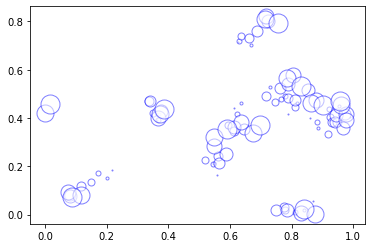

In [13]:
# Create points for 10 particles and 10 time steps. 
n_part, n_time = 10, 10
coords = np.zeros((n_time, 3, n_part))
coords[0, :, :] = np.random.rand(3, n_part)
# Quick 2-d mpl viz for identifying
for i in range(1, n_time):
    tmp = coords[i-1, :, :]+(np.random.rand(3, n_part)-0.5)/10
    tmp[tmp<0] = abs(tmp[tmp<0])   # reflection
    tmp[tmp>1] = abs(1-tmp[tmp>1]) # off walls
    coords[i, :, :] = tmp[:, :]
import matplotlib.pyplot as plt
for i in range(n_time):
    plt.plot(coords[i,0,:], coords[i,1,:], color='b', marker='o', mfc='w', ls='', ms=(1+i*2), alpha=0.5)
x0 = coords[0,0,:]
y0 = coords[0,1,:]
z0 = coords[0,2,:]
pyevtk.hl.pointsToVTK("./points", x0, y0, z0, data={'id': np.arange(0,10)})

We'll use these and other VTK files to vizualize things in VisIt (and, maybe Paraview and Mayavi).